In [1]:
# Standard Libraries
import json
import numpy as np
import matplotlib.pyplot as plt

# Data Handling and Preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# PyTorch and Deep Learning Libraries
import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

# Hugging Face Transformers
from transformers import BertTokenizer, BertForSequenceClassification

In [2]:


# Load JSONL data from file
data = []

with open('review_with_aspect.jsonl', 'r') as file:
    for line in file:
        # Parse each line (JSON object) and append it to the data list
        data.append(json.loads(line))

# Check the first entry to ensure it loaded correctly
#print(data[0])  # Example to check the first review

# Defining the aspect labels
aspect_labels = [
    "summary", "motivation_positive", "clarity_positive", "soundness_negative",
    "substance_negative", "meaningful_comparison_negative", "soundness_negative",
    "substance_positive", "clarity_negative", "originality_positive", "originality_negative",
    "replicability_negative", "soundness_positive", "replicability_positive",
    "motivation_negative", "clarity_positive"
]

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Custom Dataset for Multi-Label Classification
class ReviewDataset(Dataset):
    def __init__(self, reviews, aspect_labels, tokenizer, max_len):
        self.reviews = reviews
        self.aspect_labels = aspect_labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        label = self.aspect_labels[idx]

        # Tokenize the review text
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )


        labels = torch.tensor(label, dtype=torch.float)

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': labels
        }

# A binary vector for each aspect (1 for presence, 0 for absence)
def prepare_data(data):
    reviews = []
    aspect_vectors = []

    for entry in data:
        text = entry['text']
        labels = entry['labels']

        # Initialize aspect vector with 0 (False)
        aspect_vector = [0] * len(aspect_labels)

        # Mark aspects present in the review
        for label in labels:
            aspect_name = label[2]
            if aspect_name in aspect_labels:
                index = aspect_labels.index(aspect_name)
                aspect_vector[index] = 1

        reviews.append(text)
        aspect_vectors.append(aspect_vector)

    return reviews, aspect_vectors

# Prepare data
reviews, aspect_vectors = prepare_data(data)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Split data into training (70%) and validation (30%) sets
X_train, X_val, y_train, y_val = train_test_split(reviews, aspect_vectors, test_size=0.3, random_state=42)

# Split validation set into validation (15%) and test (15%) sets
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

# Parameters
max_len = 512
batch_size = 8

# DataLoader for training, validation, and testing
train_dataset = ReviewDataset(X_train, y_train, tokenizer, max_len)
val_dataset = ReviewDataset(X_val, y_val, tokenizer, max_len)
test_dataset = ReviewDataset(X_test, y_test, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kaan-topcu (topcu-kaan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20
Train Loss: 0.3659, Train Accuracy: 0.8275
Validation Loss: 0.2840, Validation Accuracy: 0.8778
Epoch 2/20
Train Loss: 0.2490, Train Accuracy: 0.8945
Validation Loss: 0.2516, Validation Accuracy: 0.8988
Epoch 3/20
Train Loss: 0.1936, Train Accuracy: 0.9228
Validation Loss: 0.2593, Validation Accuracy: 0.9002
Epoch 4/20
Train Loss: 0.1543, Train Accuracy: 0.9412
Validation Loss: 0.2705, Validation Accuracy: 0.8997
Early stopping triggered. Stopping training.


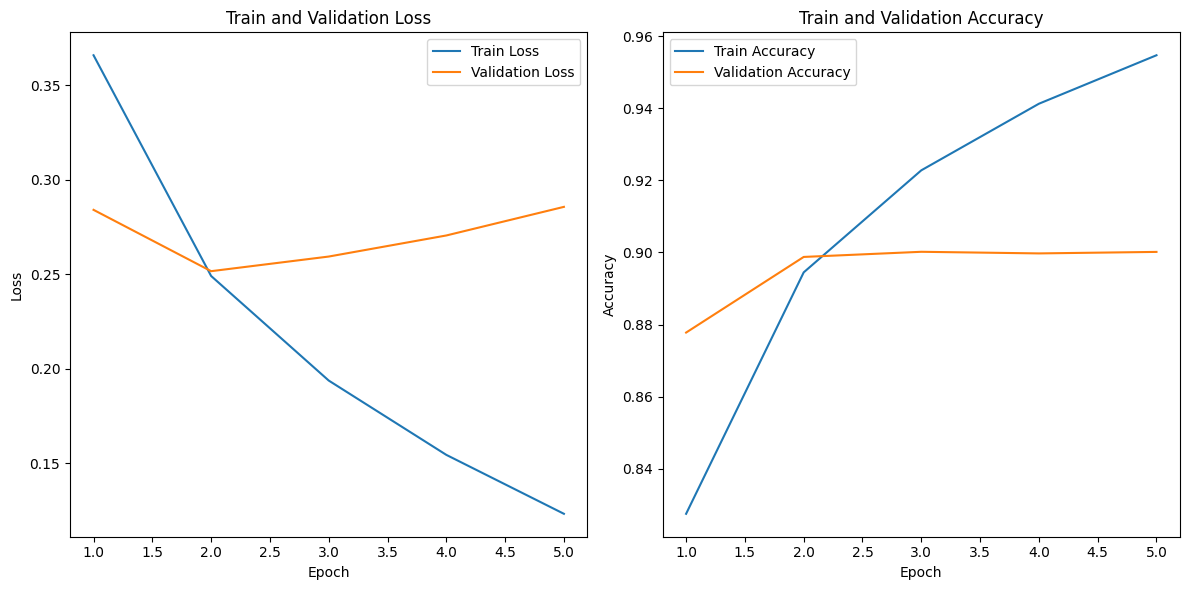

['/content/wandb/run-20250625_193543-7y9bx67n/files/final_model.pth']

In [4]:
import wandb
import torch
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification

# Initialize W&B
wandb.init(project="aspect-based-sentiment-analysis", entity="topcu-kaan")  # Replace with your actual username and project name

# Hyperparameters
epochs = 20
batch_size = 8
learning_rate = 2e-5
patience = 3  # Early stopping patience

# Log hyperparameters to W&B
wandb.config.update({
    "epochs": epochs,
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "patience": patience
})

# Load pre-trained BERT model for multi-label classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(aspect_labels))

# Optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Training loop with validation and early stopping
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Store the training and validation loss/accuracy for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Early stopping parameters
best_val_loss = float('inf')
counter = 0

# Number of epochs
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    correct_train_preds = 0
    total_train_preds = 0

    # Training phase
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        # Calculate accuracy for training
        logits = outputs.logits
        preds = (logits > 0.5).float()
        correct_train_preds += (preds == labels).sum().item()
        total_train_preds += labels.numel()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train_preds / total_train_preds

    # Validation phase
    model.eval()
    total_val_loss = 0
    correct_val_preds = 0
    total_val_preds = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

            # Calculate accuracy for validation
            logits = outputs.logits
            preds = (logits > 0.5).float()
            correct_val_preds += (preds == labels).sum().item()
            total_val_preds += labels.numel()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val_preds / total_val_preds

    # Store values for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Log to W&B
    wandb.log({
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "train_accuracy": train_accuracy,
        "val_accuracy": val_accuracy,
        "epoch": epoch + 1
    })

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered. Stopping training.")
            break

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plotting training and validation loss/accuracy
plt.figure(figsize=(12, 6))

# Plot train and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# Plot train and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Save the final model
torch.save(model.state_dict(), "final_model.pth")

# Save the model to W&B
wandb.save("final_model.pth")


In [5]:
# Evaluation
model.eval()

predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        pred = (logits > 0.5).cpu().numpy()
        predictions.extend(pred)
        true_labels.extend(labels.cpu().numpy())

# Evaluate metrics
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='micro')

print(f"Test Accuracy: {accuracy}")
print(f"Test F1-Score: {f1}")

Test Accuracy: 0.23063109286813752
Test F1-Score: 0.8239458914951792


# Logistic Regression

In [6]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.multioutput import MultiOutputClassifier


# aspect labels
unique_labels = ['clarity_negative', 'clarity_positive', 'meaningful_comparison_negative', 'motivation_negative', 'motivation_positive',
                 'originality_negative', 'originality_positive', 'replicability_negative', 'replicability_positive', 'soundness_negative',
                 'soundness_positive', 'substance_negative', 'substance_positive', 'summary']



# Extract reviews and labels
reviews = [entry["text"] for entry in data]
labels = [entry["labels"] for entry in data]

# aspect vectors
def create_aspect_vectors(reviews, labels, aspect_labels):
    aspect_vectors = []

    for i, review in enumerate(reviews):
        # Initialize aspect vector for each review, all zeros initially
        aspect_vector = np.zeros(len(aspect_labels))

        # Iterate over the labels to mark the presence of each aspect
        for label in labels[i]:
            start, end, aspect = label
            # If the aspect is present in the review, mark it as 1 in the vector
            if aspect in aspect_labels:
                aspect_index = aspect_labels.index(aspect)
                aspect_vector[aspect_index] = 1

        aspect_vectors.append(aspect_vector)

    return aspect_vectors

# Generate aspect vectors
aspect_vectors = create_aspect_vectors(reviews, labels, unique_labels)

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(reviews, aspect_vectors, test_size=0.2, random_state=42)

# TF-IDF Vectorization (Convert the reviews into numerical data)
vectorizer = TfidfVectorizer(max_features=5000)  #
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

multi_output_model = MultiOutputClassifier(lr_model, n_jobs=-1)

# Train the model
multi_output_model.fit(X_train_tfidf, y_train)

# Predict and evaluate the model
y_train_pred = multi_output_model.predict(X_train_tfidf)
y_test_pred = multi_output_model.predict(X_test_tfidf)

# Evaluation metrics
# Accuracy for each aspect
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# F1 Score for each aspect
train_f1 = f1_score(y_train, y_train_pred, average='micro')
test_f1 = f1_score(y_test, y_test_pred, average='micro')

# Precision and Recall for each aspect
train_precision = precision_score(y_train, y_train_pred, average='micro')
test_precision = precision_score(y_test, y_test_pred, average='micro')

train_recall = recall_score(y_train, y_train_pred, average='micro')
test_recall = recall_score(y_test, y_test_pred, average='micro')

# Evaluation results
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train F1-Score: {train_f1:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Train Recall: {train_recall:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Individual aspect-wise performance
for i, aspect in enumerate(unique_labels):
    # Get the predictions and ground truth for the i-th aspect
    aspect_train_true = [y_train[j][i] for j in range(len(y_train))]
    aspect_train_pred = [y_train_pred[j][i] for j in range(len(y_train_pred))]

    aspect_test_true = [y_test[j][i] for j in range(len(y_test))]
    aspect_test_pred = [y_test_pred[j][i] for j in range(len(y_test_pred))]

    # Calculate accuracy for the aspect
    aspect_train_accuracy = accuracy_score(aspect_train_true, aspect_train_pred)
    aspect_test_accuracy = accuracy_score(aspect_test_true, aspect_test_pred)

    print(f"Aspect: {aspect}")
    print(f"  Train Accuracy: {aspect_train_accuracy:.4f}")
    print(f"  Test Accuracy: {aspect_test_accuracy:.4f}")


Train Accuracy: 0.0983
Test Accuracy: 0.0681
Train F1-Score: 0.7047
Test F1-Score: 0.6505
Train Precision: 0.8554
Test Precision: 0.7978
Train Recall: 0.5991
Test Recall: 0.5491
Aspect: clarity_negative
  Train Accuracy: 0.8044
  Test Accuracy: 0.7776
Aspect: clarity_positive
  Train Accuracy: 0.8608
  Test Accuracy: 0.8117
Aspect: meaningful_comparison_negative
  Train Accuracy: 0.8346
  Test Accuracy: 0.8147
Aspect: motivation_negative
  Train Accuracy: 0.8941
  Test Accuracy: 0.8894
Aspect: motivation_positive
  Train Accuracy: 0.7784
  Test Accuracy: 0.7386
Aspect: originality_negative
  Train Accuracy: 0.8322
  Test Accuracy: 0.8088
Aspect: originality_positive
  Train Accuracy: 0.7811
  Test Accuracy: 0.7322
Aspect: replicability_negative
  Train Accuracy: 0.8862
  Test Accuracy: 0.8750
Aspect: replicability_positive
  Train Accuracy: 0.9893
  Test Accuracy: 0.9921
Aspect: soundness_negative
  Train Accuracy: 0.7661
  Test Accuracy: 0.7128
Aspect: soundness_positive
  Train Accur